In [10]:
import logging

# to be added to requirements.txt
import seaborn as sns
from sklearn.decomposition import PCA

import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform

from project_panaroma import Stitcher

logging.basicConfig(level=logging.INFO)


class HierarchicalClustering:
    def __init__(self, distance_matrix):
        self.distance_matrix = distance_matrix.copy()
        self.num_images = distance_matrix.shape[0]
        self.clusters = [[i] for i in range(self.num_images)]
        self.distances = self._convert_similarity_to_distance(distance_matrix)

    def _convert_similarity_to_distance(self, similarity_matrix):
        # Convert similarity scores to distances
        # Adding epsilon to avoid division by zero
        epsilon = 1e-5
        distance_matrix = 1 / (similarity_matrix + epsilon)
        np.fill_diagonal(distance_matrix, 0)
        return distance_matrix

    def fit(self, num_clusters=1):
        while len(self.clusters) > num_clusters:
            # Find the two clusters with the smallest distance
            min_distance = np.inf
            x, y = -1, -1
            for i in range(len(self.clusters)):
                for j in range(i + 1, len(self.clusters)):
                    dist = self._cluster_distance(self.clusters[i], self.clusters[j])
                    if dist < min_distance:
                        min_distance = dist
                        x, y = i, j
            if x == -1 or y == -1:
                break  # No more clusters to merge
            # Merge clusters x and y
            self.clusters[x].extend(self.clusters[y])
            del self.clusters[y]
            logging.info(
                f"Merged clusters {x} and {y}, new cluster: {self.clusters[x]}"
            )
        return self.clusters

    def _cluster_distance(self, cluster1, cluster2):
        # Compute the average linkage distance between two clusters
        distances = [self.distances[i][j] for i in cluster1 for j in cluster2]
        return np.mean(distances)


class StitcherWithRecommender(Stitcher):
    def compute_pairwise_similarities(self):
        num_images = len(self.input_images)
        similarity_matrix = np.zeros((num_images, num_images))

        for i in range(num_images):
            kp1, des1 = self.feature_points_and_descriptors[i]
            for j in range(i + 1, num_images):
                kp2, des2 = self.feature_points_and_descriptors[j]
                good_matches = self.match_features_call(des1, des2)
                similarity_score = len(good_matches)
                similarity_matrix[i, j] = similarity_score
                similarity_matrix[j, i] = similarity_score  # Symmetric matrix
                print(
                    f"Similarity between image {i+1} and image {j+1}: {similarity_score} good matches"
                )

        return similarity_matrix

    def plot_distance_matrix_heatmap(self, distance_matrix):
        plt.figure(figsize=(10, 8))
        sns.heatmap(distance_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True,
                    xticklabels=[f"Image {i+1}" for i in range(distance_matrix.shape[0])],
                    yticklabels=[f"Image {i+1}" for i in range(distance_matrix.shape[0])])
        plt.title("Distance Matrix Heatmap")
        plt.xlabel("Images")
        plt.ylabel("Images")
        plt.show()
    
    def generate_dendrogram(self, similarity_matrix):
        # Convert the similarity matrix to a distance matrix
        epsilon = 1e-5  # Small value to prevent division by zero
        distance_matrix = 1 / (similarity_matrix + epsilon)
        np.fill_diagonal(distance_matrix, 0)  # Ensure the diagonal is zero

        # Convert the distance matrix to condensed form
        condensed_distance = squareform(distance_matrix)

        # Generate the linkage matrix using average linkage
        linked = linkage(condensed_distance, method="average")

        fig, ax = plt.subplots(figsize=(10, 7))
        dendrogram_data = dendrogram(
            linked,
            labels=[f"Image {i+1}" for i in range(similarity_matrix.shape[0])],
            ax=ax,
        )
        plt.title("Dendrogram of Image Similarities")
        plt.xlabel("Images")
        plt.ylabel("Distance")

        # Load images and display them below the dendrogram
        num_labels = len(dendrogram_data["ivl"])
        image_height = 0.1  # Adjust as needed

        # Get the x positions of the leaves
        xlbls = ax.get_xticks()
        xlbls = ax.get_xticks()

        for i, label in enumerate(dendrogram_data["ivl"]):
            image_index = int(label.split()[-1]) - 1
            img = cv2.cvtColor(self.input_images[image_index], cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (50, 50))

            # Get the x position of the label
            x = xlbls[i]
            y = 0  # y-position can be zero as we're only interested in x

            # Transform x position from data to figure coordinates
            trans = ax.transData.transform((x, y))
            inv = fig.transFigure.inverted()
            x_fig, y_fig = inv.transform(trans)

            # Width of each image in figure coordinates
            width = (
                1 / num_labels * 0.8
            )  # Adjust 0.8 to increase spacing between images
            x_fig_centered = x_fig - width / 2

            # Add new axes at the calculated position
            img_ax = fig.add_axes(
                [x_fig_centered, 0.01, width, image_height], anchor="S", zorder=1
            )
            img_ax.imshow(img)
            img_ax.axis("off")

        plt.subplots_adjust(bottom=0.3)  # Adjust to make space for images
        plt.show()

    def recommend_images(self, num_clusters=1):
        similarity_matrix = self.compute_pairwise_similarities()
        self.generate_dendrogram(similarity_matrix)  # dendrogram before clustering
        hc = HierarchicalClustering(similarity_matrix)
        clusters = hc.fit(num_clusters=num_clusters)
        recommendations = []
        for idx, cluster in enumerate(clusters):
            print(f"Cluster {idx + 1}: {[i + 1 for i in cluster]}")
            recommendations.append([self.input_images[i] for i in cluster])
        return recommendations

    def stitch_recommended_images(self, recommended_image_groups):
        for idx, image_group in enumerate(recommended_image_groups):
            self.input_images = image_group
            self.feature_points_and_descriptors = []
            self.detect_keypoints_and_descriptors()
            self.stitch3_with_post()
            print(f"Stitched panorama for cluster {idx + 1} saved.")
        
    def plot_pca_feature_space(self, distance_matrix):
        # Apply PCA to reduce the distance matrix to 2D
        pca = PCA(n_components=2)
        pca_result = pca.fit_transform(distance_matrix)

        # Plot the 2D feature space
        plt.figure(figsize=(10, 8))
        plt.scatter(pca_result[:, 0], pca_result[:, 1], s=100)

        # Label each point with its corresponding image index
        for i in range(pca_result.shape[0]):
            plt.text(pca_result[i, 0], pca_result[i, 1], f"Image {i+1}",
                     fontsize=12, ha="center")

        plt.title("PCA of Feature Space (2D)")
        plt.xlabel("PCA Component 1")
        plt.ylabel("PCA Component 2")
        plt.show()



In [11]:
# Assuming `stitcher` is an instance of the Stitcher class
stitcher = StitcherWithRecommender()
stitcher.input_dir = "data/gallery_of_3s"
stitcher.output_dir = "data/gallery_of_3s_outputs"
stitcher.plot = False

stitcher.read_input_dir()
stitcher.detect_keypoints_and_descriptors()

Found 9 images in the input directory.
Detected 1659 keypoints in image 1 using SIFT.
Detected 1213 keypoints in image 2 using SIFT.
Detected 2921 keypoints in image 3 using SIFT.
Detected 971 keypoints in image 4 using SIFT.
Detected 1270 keypoints in image 5 using SIFT.
Detected 1391 keypoints in image 6 using SIFT.
Detected 812 keypoints in image 7 using SIFT.
Detected 470 keypoints in image 8 using SIFT.
Detected 357 keypoints in image 9 using SIFT.
Feature detection completed.


Found 200 good matches after ratio test.
Similarity between image 1 and image 2: 200 good matches
Found 36 good matches after ratio test.
Similarity between image 1 and image 3: 36 good matches
Found 33 good matches after ratio test.
Similarity between image 1 and image 4: 33 good matches
Found 21 good matches after ratio test.
Similarity between image 1 and image 5: 21 good matches
Found 22 good matches after ratio test.
Similarity between image 1 and image 6: 22 good matches
Found 8 good matches after ratio test.
Similarity between image 1 and image 7: 8 good matches
Found 25 good matches after ratio test.
Similarity between image 1 and image 8: 25 good matches
Found 26 good matches after ratio test.
Similarity between image 1 and image 9: 26 good matches
Found 294 good matches after ratio test.
Similarity between image 2 and image 3: 294 good matches
Found 31 good matches after ratio test.
Similarity between image 2 and image 4: 31 good matches
Found 46 good matches after ratio test

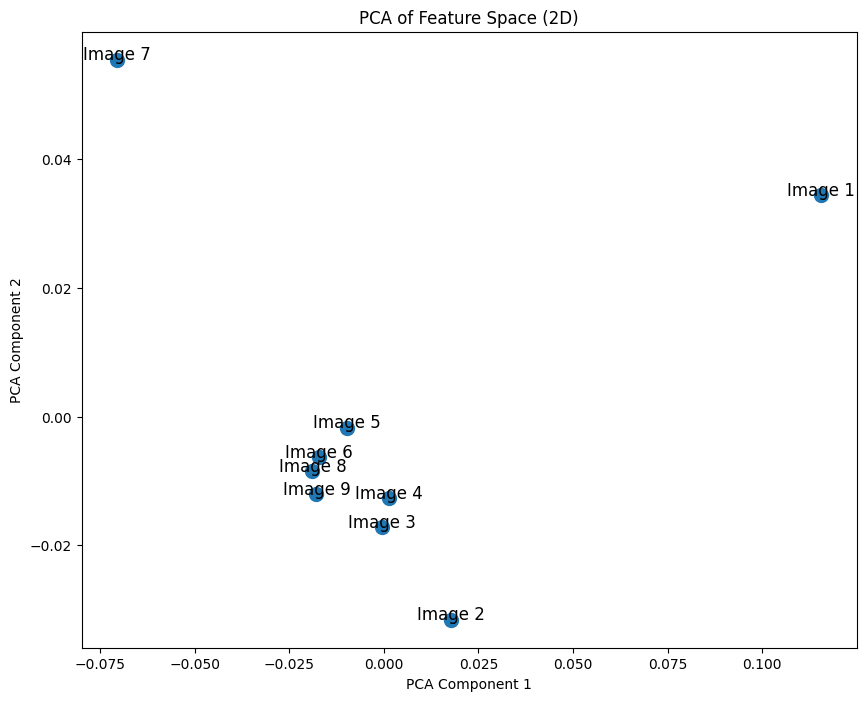

In [13]:

# Compute the similarity matrix for the images
similarity_matrix = stitcher.compute_pairwise_similarities()

# Convert similarity matrix to distance matrix
hc = HierarchicalClustering(similarity_matrix)
distance_matrix = hc._convert_similarity_to_distance(similarity_matrix)

# Plot PCA visualization of the feature space
stitcher.plot_pca_feature_space(distance_matrix)

In [6]:
# Compute the similarity matrix for the images
similarity_matrix = stitcher.compute_pairwise_similarities()

# Create an instance of HierarchicalClustering to convert similarity to distance
hc = HierarchicalClustering(similarity_matrix)
distance_matrix = hc._convert_similarity_to_distance(similarity_matrix)

Found 200 good matches after ratio test.
Similarity between image 1 and image 2: 200 good matches
Found 36 good matches after ratio test.
Similarity between image 1 and image 3: 36 good matches
Found 33 good matches after ratio test.
Similarity between image 1 and image 4: 33 good matches
Found 21 good matches after ratio test.
Similarity between image 1 and image 5: 21 good matches
Found 22 good matches after ratio test.
Similarity between image 1 and image 6: 22 good matches
Found 8 good matches after ratio test.
Similarity between image 1 and image 7: 8 good matches
Found 25 good matches after ratio test.
Similarity between image 1 and image 8: 25 good matches
Found 26 good matches after ratio test.
Similarity between image 1 and image 9: 26 good matches
Found 294 good matches after ratio test.
Similarity between image 2 and image 3: 294 good matches
Found 31 good matches after ratio test.
Similarity between image 2 and image 4: 31 good matches
Found 46 good matches after ratio test

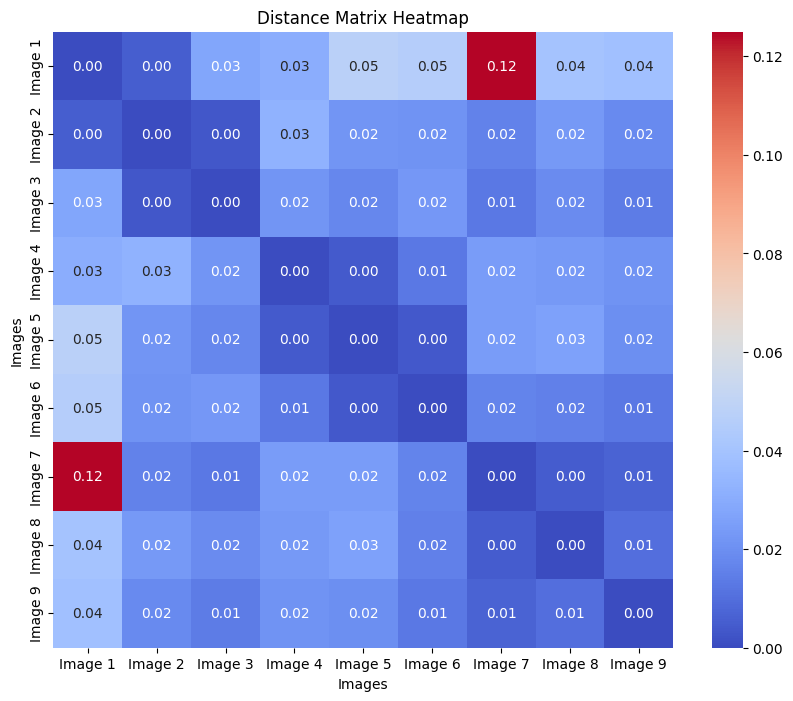

In [7]:

# Plot the heatmap of the initial distance matrix
stitcher.plot_distance_matrix_heatmap(distance_matrix)


Found 200 good matches after ratio test.
Similarity between image 1 and image 2: 200 good matches
Found 36 good matches after ratio test.
Similarity between image 1 and image 3: 36 good matches
Found 33 good matches after ratio test.
Similarity between image 1 and image 4: 33 good matches
Found 21 good matches after ratio test.
Similarity between image 1 and image 5: 21 good matches
Found 22 good matches after ratio test.
Similarity between image 1 and image 6: 22 good matches
Found 8 good matches after ratio test.
Similarity between image 1 and image 7: 8 good matches
Found 25 good matches after ratio test.
Similarity between image 1 and image 8: 25 good matches
Found 26 good matches after ratio test.
Similarity between image 1 and image 9: 26 good matches
Found 294 good matches after ratio test.
Similarity between image 2 and image 3: 294 good matches
Found 31 good matches after ratio test.
Similarity between image 2 and image 4: 31 good matches
Found 46 good matches after ratio test

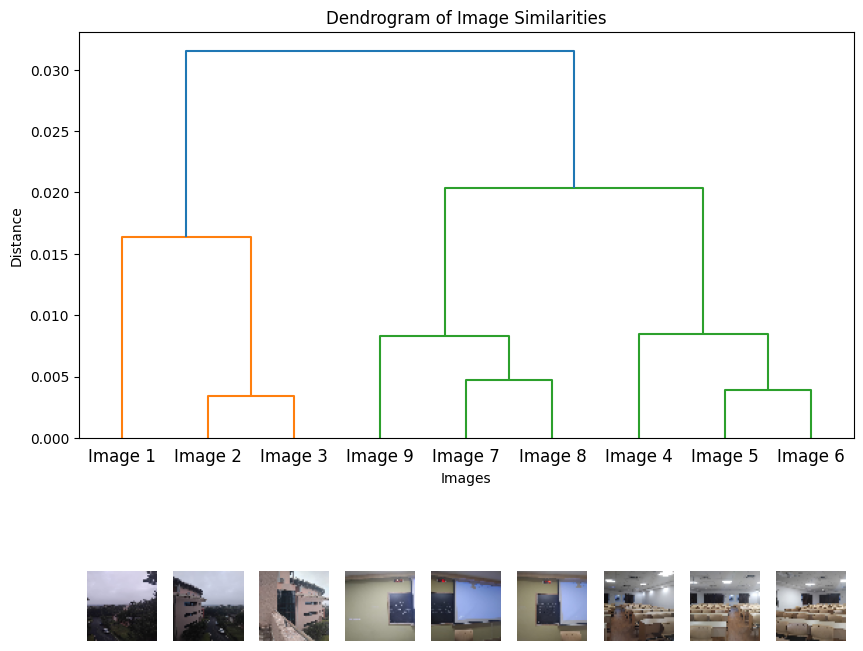

INFO:root:Merged clusters 1 and 2, new cluster: [1, 2]
INFO:root:Merged clusters 3 and 4, new cluster: [4, 5]
INFO:root:Merged clusters 4 and 5, new cluster: [6, 7]
INFO:root:Merged clusters 4 and 5, new cluster: [6, 7, 8]
INFO:root:Merged clusters 2 and 3, new cluster: [3, 4, 5]
INFO:root:Merged clusters 0 and 1, new cluster: [0, 1, 2]


Cluster 1: [1, 2, 3]
Cluster 2: [4, 5, 6]
Cluster 3: [7, 8, 9]
Detected 1659 keypoints in image 1 using SIFT.
Detected 1213 keypoints in image 2 using SIFT.
Detected 2921 keypoints in image 3 using SIFT.
Feature detection completed.
Detected 15455 keypoints in image using SIFT.
Detected 23318 keypoints in image using SIFT.
Preprocessed Stitched image saved to data/gallery_of_3s_outputs
Stitched panorama for cluster 1 saved.
Detected 971 keypoints in image 1 using SIFT.
Detected 1270 keypoints in image 2 using SIFT.
Detected 1391 keypoints in image 3 using SIFT.
Feature detection completed.
Detected 3462 keypoints in image using SIFT.
Detected 4205 keypoints in image using SIFT.
Preprocessed Stitched image saved to data/gallery_of_3s_outputs
Stitched panorama for cluster 2 saved.
Detected 812 keypoints in image 1 using SIFT.
Detected 470 keypoints in image 2 using SIFT.
Detected 357 keypoints in image 3 using SIFT.
Feature detection completed.
Detected 797 keypoints in image using SIFT.

In [8]:

recommended_image_groups = stitcher.recommend_images(
    num_clusters=len(stitcher.input_images) // 3
)
stitcher.stitch_recommended_images(recommended_image_groups)
similarity_matrix = stitcher.compute_pairwise_similarities()

hc = HierarchicalClustering(similarity_matrix)

distance_matrix = hc._convert_similarity_to_distance(similarity_matrix)

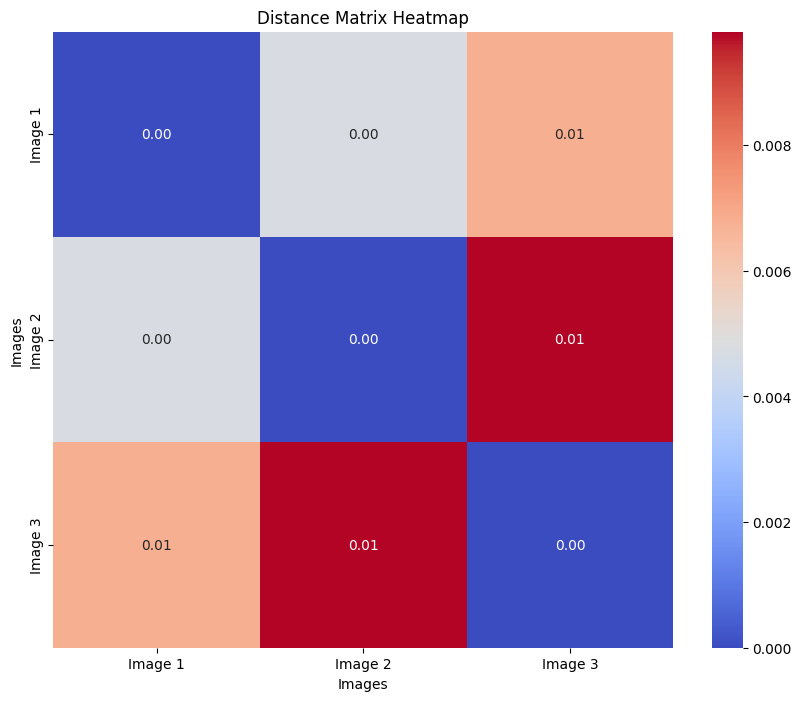

In [9]:
stitcher.plot_distance_matrix_heatmap(distance_matrix)